In [1]:
import pandas as pd
import numpy as np
import re
import math

import requests, json
import pandas as pd

NOTION_TOKEN = "secret_AIc5tovrF5rnoYWC54z9CzwQUNb5d2A1q3HPKwOEqup"
DATABASE_ID = "213b4ff8bb884cfc987139ae53aa4396"

headers = {
    "Authorization": "Bearer " + NOTION_TOKEN,
    "Content-Type": "application/json",
    "Notion-Version": "2022-06-28",
}

DATABASE_ID_LIST = ["db2b026a03f0442f828bc88dcdbf143c", "c238334399d54b10aad0bcb84cb77d5c", "bf7efa466c624f1ca200d05c5cf34f58", "2f0e230f82974dd09841ae871cb558f9", "b708c8576ea34bb385d24aedc5b1277b", "d6211c2113914ecc86332d4bb305a115", "a8b0289c72eb4daaa1063152eb5e787a", "73e5dc61f97f4f2095c0265f2dae70d8", "1a91276509b246dda4c170a248d096c2", "6a374753947e42f7aa57fac3a474b78f"]
YEAR_LIST = [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]

def readDatabase(DATABASE_ID_LIST, YEAR_LIST, headers):
    for id in zip(DATABASE_ID_LIST, YEAR_LIST):
        readUrl = f"https://api.notion.com/v1/databases/{id[0]}/query"
        res = requests.request("POST", readUrl, headers=headers)
        data = res.json()
        print(res.status_code)

        if res.status_code == 200:
            try:
                with open(f"./{id[1]}.json", 'w', encoding='utf8') as f:
                    json.dump(data, f, ensure_ascii=False)
            except:
                continue
            
readDatabase(DATABASE_ID_LIST, YEAR_LIST, headers)

def jsonToDataFrame(YEAR_LIST):
    temp = {}
    year_list = []
    name = []
    birth = []
    registered = []
    fullTime = []
    responsibilities = []
    career = []
    stock = []
    time1 = []
    time2 = []
    position = []

    for year in YEAR_LIST:
        with open(f"./{year}.json", 'r') as f:
            json_data = json.load(f)
            for i in range(len(json_data['results'])):
                properties = json_data['results'][i]['properties']
                year_list.append(year)
                for key in properties:
                    if key == '이름':
                        name.append(properties[key]['title'][0]['text']['content'])
                    elif key == '출생년월':
                        birth.append(properties[key]['rich_text'][0]['text']['content'])
                    elif key == '등기임원 여부':
                        registered.append(properties[key]['rich_text'][0]['text']['content'])
                    elif key == '상근 여부':
                        fullTime.append(properties[key]['rich_text'][0]['text']['content'])
                    elif key == '담당업무':
                        responsibilities.append(properties[key]['rich_text'][0]['text']['content'])
                    elif key == '주요경력':
                        career.append(properties[key]['rich_text'][0]['text']['content'])
                    elif key == '의결권 있는 주식수':
                        stock.append(properties[key]['number'])
                    elif key == '재직기간':
                        time1.append(properties[key]['rich_text'][0]['text']['content'])
                    elif key == '임기만료일':
                        time2.append(properties[key]['rich_text'][0]['text']['content'])
                    elif key == '직위':
                        position.append(properties[key]['rich_text'][0]['text']['content'])

    temp['이름'] = name
    temp['연도'] = year_list
    temp['출생년월'] = birth
    temp['등기임원 여부'] = registered
    temp['상근 여부'] = fullTime
    temp['담당업무'] = responsibilities
    temp['주요경력'] = career
    temp['의결권 있는 주식수'] = stock
    temp['재직기간'] = time1
    temp['임기만료일'] = time2
    temp['직위'] = position
    return temp

dict = jsonToDataFrame(YEAR_LIST)

df = pd.DataFrame.from_dict(data=dict, orient='columns')

200
200
200
200
200
200
200
200
200
200


In [2]:
df['의결권 있는 주식수'].fillna(0.0, inplace=True)
#'\xa0' 처리
df['주요경력']=df['주요경력'].str.replace('\xa0', '')
#대학, 전공 피처 생성
temp=df['주요경력'].str.split('\n')
colleges=temp.str.get(0)

#추가로 처리해줘야될 대학 form 맞춰주기
colleges[colleges== 'University of Bath 사회과학대학원(석사)'] ='UniversityofBath 사회과학대학원(석사)'
colleges[colleges== 'Florida International University 경영대학원(박사)']='FloridaInternationalUniversity 경영대학원(박사)'
colleges[colleges== 'Ohio State University 정책대학원(박사)'] = 'OhioStateUniversity 정책대학원(박사)'
colleges[colleges== 'KDI국제정책대학원(석사)'] = 'KDI 국제정책대학원(석사)'
colleges[colleges== '상명여자사범대'] = '상명여자사범대 교육학'
colleges[colleges== '한국외국어대경영학(석사)'] = '한국외국어대 경영학(석사)'
colleges[colleges== '미시간대학교 경영대학원 MBA'] = '미시간대학교 경영대학원MBA'

#대학, 전공으로 나누기
ttemp = colleges.str.split() 

#대학 피처 생성
df['대학교']=ttemp.str.get(0)

#전공 피처 생성
tttemp = ttemp.str.get(1)
tttemp=tttemp.replace(r'\([^)]*\)', '', regex=True)
df['전공']=tttemp

#근속연수 생성
def create_work_years(x):
  temp = re.split(r'~|~\n', x)
  temp[0] = temp[0].strip()
  temp[1] = temp[1].strip()
  return int(temp[1][:4]) - int(temp[0][:4])

df['근속연수'] = df['재직기간'].apply(lambda x : create_work_years(x))

#주요경력 전처리
def replace_career(x):
  temp = [string.split() for string in re.split(r'\n |\n', x)]
  if len(temp)==1 :
    return {'대신증권'}
  else:
    return set(list(zip(*temp[1:]))[0])

df['주요경력요약'] = df['주요경력'].apply(lambda x : replace_career(x))

In [3]:
df_2014 = df[df['연도']==2014].reset_index(drop=True)
df_2015 = df[df['연도']==2015].reset_index(drop=True)
df_2016 = df[df['연도']==2016].reset_index(drop=True)
df_2017 = df[df['연도']==2017].reset_index(drop=True)
df_2018 = df[df['연도']==2018].reset_index(drop=True)
df_2019 = df[df['연도']==2019].reset_index(drop=True)
df_2020 = df[df['연도']==2020].reset_index(drop=True)
df_2021 = df[df['연도']==2021].reset_index(drop=True)
df_2022 = df[df['연도']==2022].reset_index(drop=True)
df_2023 = df[df['연도']==2023].reset_index(drop=True)

In [4]:
#학교 거리 계산
def cal_college(df1, df2, alpha = 0.7):
  #지역별로 나눔
  college_dict = {'서울경기':['상명여자사범대', '서울대', '홍익대', '성균관대', '연세대', '연세대학교', '동국대', '중앙대', '한국외대', '한국외국어대', '세종대학교', '세종대', '성균관대학교', '경희대', '서강대', '고려대', '건국대', '가천대', '가천대학교', '한양대', '명지대'],
                   '광역시':['부경대', '경북대', '전남대', '조선대', '한국과학기술원', '가천대', '인하대', '동아대', '대전대', '울산대', '영남공업전문대'],
                   '그외한국':['전북대', '원광대', '충북대', '충북대학교', '강원대', 'KDI'],
                   '해외':['FloridaInternationalUniversity', 'OhioStateUniversity', 'UniversityofBath', '조지아공대', 'Brown대', '카네기멜론대', '미시간대학교']}

  #키값 찾기
  for key, val in college_dict.items() :
    if df1['대학교'] in val :
      df1_key = key
    if df2['대학교'] in val :
      df2_key = key
          
  #k값 구하기
  if df1['대학교'] == df2['대학교'] :
    k=0
  elif df1_key == df2_key :
    k=1
  elif df1_key != df2_key :
    k=2

  return alpha ** k

#학과 거리 계산
def cal_department(df1, df2, alpha = 0.7):
  department_dict={'경영경제':['회계학', '세무학', '경제학', '국제경영학', '경영학', '무역학', 'MBA', '경제통상학', '경영대학원', '경영대학원MBA', '산업정보학', '금융공학', '국제금융학'],
                   '사회과학':['사회학', '사회과학대학원', '행정학', '정치외교학', '정치학', '신문방송학'],
                   '법률':['법학', '사법학', '정책대학원', '국제정책대학원'],
                   '인문':['불어불문학'],
                   '기타':['교육학', '인적자원개발학'],
                   '자연':['응용통계학', '통계학', '수학'],
                   '공학':['기계공학', '화학공학', '전자계산학', '전자전산학', '전산학', '항공우주학']}

  #키값 찾기
  for key, val in department_dict.items() :
    if df1['전공'] in val :
      df1_key = key
    if df2['전공'] in val :
      df2_key = key
          
  #k값 구하기
  if df1['전공'] == df2['전공'] :
    k=0
  elif df1_key == df2_key :
    k=1
  elif df1_key != df2_key :
    k=2

  return alpha ** k

#직위 거리 계산
def cal_position(df1, df2, alpha = 0.7):
  position_dict={'회장':0, '대표이사':1, '부회장':2, '사장':3, '부사장':4, '전무':5, '상무': 6, '상무보':7, '이사대우부문장':8, '이사대우담당':8, '사외이사':99, '감사위원':99}

  #value값 찾기
  df1_value = position_dict[df1['직위']]
  df2_value = position_dict[df2['직위']]

  #k값 구하기
  if df1['직위'] == df2['직위'] :
    k=0
  elif df1_value == 99 or df2_value == 99 : #사외이사 혹은 감사인원(회사밖 인물)은 모두와 거리 4(최대차이의 중간값// 회장, 이사대우담당과의 거리)
    k=4
  else :
    k=abs(df1_value - df2_value) #값 차이만큼 거리

  return alpha ** k

# 근속연수 거리 계산
def cal_work_years(df1, df2, alpha = 0.7):
  #k값 구하기
  if df1['근속연수'] == df2['근속연수'] :
    k=0
  else :
    if abs(df1['근속연수'] - df2['근속연수']) % 5 ==0:    #근속연수 차이 5년 기준으로 1씩 증가 (차이 1~5/6~10/11~15/...같은그룹)
      k= abs(df1['근속연수'] - df2['근속연수']) // 5 
    else:
      k= 1 + abs(df1['근속연수'] - df2['근속연수']) // 5 

  return alpha ** k  

#담당업무 거리 계산
def cal_task(df1, df2, alpha = 0.7):
  task_dict={'IT계열': {'IT':['IT부문장', 'IT본부장', 'IT서비스본부장', '디지털부문장', '스마트Biz본부장', 'Operation&Technology본부장'], '정보보호':['정보보호부문장', '정보보호담당']},
             '본사영업':{'Wolesale':['Wholesale부문장','Wholesale영업본부장', 'Wholesale사업단장', 'Trading부문장', 'Trading Center장', 'Sales&Trading총괄', '대외협력담당'], 
                     'IB':['IB사업단장', 'IB부문장', 'IB부부문장', 'IB1부문장', 'IB2부문장', 'IPO담당',  'PF부문장', 'PF1본부장', '구조화상품본부장'], 
                     '영업':['영업부장']},
             '본사관리':{'리테일':['리테일총괄', 'Club1962센터장','WM추진부문장', 'WM추진본부장', 'WM사업단장'],
                     '리스크':['리스크관리부문장', '리스크관리담당'] ,
                     '경영':['경영전략총괄', '전략지원부문장', '전략지원담당', '경영지원본부장', '경영지원부문장', '경영기획부문장', '경영기획본부장', '기획본부장', '기획본부장 / 투자금융담당', '전략지원부문장/프라이빗라운지 부문장'], 
                     '상품':['Product부문장', 'Solution&Product사업단장'],
                     '업무':['업무총괄',  '업무총괄(IB사업단, 고객자산본부 제외)', '업무총괄(IB사업단,고객자산본부 제외)', '업무총괄 (IB사업단,고객자산본부 제외)', '업무총괄(IB사업단, 고객자산본부, 경영지원본부, 정보보호부문, 준법지원부문, 감사부문 제외)'], 
                     '금융':['기업금융담당', '스마트금융본부장', '금융주치의추진본부장', '금융주치의사업단장'], 
                     '인사,인프라':['인재역량센터장', '인프라관리본부장'],
                     '법률':['준법감시인\n 준법지원부문장', '준법감시인 준법지원부문장', '준법감시인\n준법지원부문장', '준법감시인\n준법지원담당', '준법감시인/준법지원부문장', '준법감시인 / 준법지원담당', 'Advisory본부장'], 
                     '감사':['감사위원장', '감사부문장', '감사위원', '상근감사위원', '감사담당'], 
                     '언론홍보':['홍보부문장', 'Coverage본부장']},
             '리서치': {'리서치센터':['Research Center장', '리서치센터장', 'Market\n  Solution부문장', 'Research&Strategy본부장', 'Market Solution부문장', 'Market Solution 부문장']},
             '고객':{'고객자산':['고객자산부문장', '고객자산부문 부부문장', '고객자산본부장', '고객자산본부장 / 홍보담당', '고객자산본부장/ 홍보담당', '고객자산본부장/ 홍보부문장', '고객자산본부장/홍보부문장', '고객자산부문장, 홍보부문장', '고객자산부문장\n홍보부문장'],
                   'WM':['서부WM부문장', '서부WM본부장', '재경1WM부문장', '재경1WM본부장', '재경2WM본부장', '재경2WM부문장', '동부WM부문장', '동부WM본부장'],
                   '프라이빗':['프라이빗부문장,\n 나인원프라이빗라운지장', '프라이빗부문장, 나인원프라이빗라운지장', '대신나인원 \n프라이빗라운지장', '프라이빗라운지 부문장 /대신나인원 프라이빗라운지장', '프라이빗부문장, 대신나인원프라이빗라운지장', '프라이빗부문장\n나인원프라이빗라운지장',], 
                   '소비자보호':['금융소비자보호부문장\n(COO)', '금융소비자보호부문장(COO)', '금융소비자보호부문장 (COO)', '금융소비자보호 총괄', '금융소비자보호총괄']},
             '기타':{'지점':['강북지역본부장', '강남지역본부장', '강남선릉센터장', '서부지역본부장', '동부지역본부장', '울산지점장'],
                   '비서':['비서실장', '비서/브랜드본부', '비서/브랜드담당'], '공란':['-']}}

   #키값 찾기
  for outerKey in task_dict.keys() :
    for key, val in task_dict[outerKey].items() :
      if df1['담당업무'] in val :
        df1_outerKey = outerKey
        df1_innerKey = key
      if df2['담당업무'] in val :
        df2_outerKey = outerKey
        df2_innerKey = key
          
          
  #k값 구하기
  if df1['담당업무'] == df2['담당업무'] : #같은업무
    k=0
  elif df1_outerKey == df2_outerKey and df1_innerKey == df2_innerKey: #상위하위 혹은 비슷한업무
    k=1
  elif df1_outerKey == df2_outerKey : #같은계열업무
    k=2
  elif df1_outerKey != df2_outerKey :
    k=3 #다른계열업무
  return alpha ** k

#경력 거리 계산
def cal_career(df1, df2, alpha = 0.7):
  career_dict={1:['대신증권', '대신증권WM사업단장', 'WM추진부문장', '재경1WM부문장', '대신증권중부지역본부장', '기획본부장대신증권', '대신증권분당지점장', '대신증권무거동지점장', '대신증권Capital', 
                  '이사대우부본부장', '기획본부장대신증권인재역량센터장', '대신증권인재전략부', '대신증권파생상품운용부장', '대신증권자산운용본부', '대신증권영업기획부장', '대신증권기획실장', 
                  '대신증권홍보실', '대신증권브랜드전략실', '대신증권IT개발부장', '대신증권트레이딩시스템부장', '대신증권Global사업본부', '신증권', '기업금융사업단장'], #대신증권
               0:['대신에프앤아이', '대신투자신탁운용', '대신투자신탁운용상무이사', '대신에이엠씨', '대신자산운용', '대신저축은행'], #대신증권 자회사
               2:['메리츠종금증권', '메리츠증권', '미래에셋증권', 'KTB투자증권', 'SC제일은행', '하나금융투자', 'IBK투자증권', 'DB금융투자', 'NH투자증권', 'KB증권', 'LIG손해보험', '굿모닝신한증권', '메릴린치증권', 
                  '삼성증권', '동양증권', '한국투자증권', '한국투자증권평촌지점', '대우증권', '대우본부장', '대우증권전략기획본부', '대우증권해외사업부문', '대우증권IB사업부문', 
                  '우리투자증권', '우리CS자산운용', '우리투자증권기업금융2팀장', '우리프라이빗에쿼티', '푸르덴셜투자증권', '하이투자증권주식인수팀',  '하이투자증권주식인수팀', 'SBC', 'Bank', '도이치은행'], #타증권사
               3:['금융감독원', '금융위원회', '現)금융위원회', '감사원', '대검찰청', '법무법인', '現)법무법인', '세무법인', '국세청', '중부지방국세청', '서울북부지방검찰청','서울지방국세청장', '서울지방국세청', 
                  '제58대', '제22대', '기획재정부', '국세청,관세청,산업통상자원부', '자본시장연구원', '한국조세연구원', '국가청렴위원회', '대한중재인협회', '한국회계정보학회', 
                  '금융위원회금융발전심의위원(현)', '금융위원회적극행정심의위원(現)', '안진회계법인',  'L&C세무회계사무소', '변호사정상명법률사무소', '피앤비세무컨설팅', '現)법무법인(유)'], #법,정책
               4:['중앙대', '중앙대학교', '現)중앙대', '연세대학교', 'KAIST', '수원대', '수원대학교', '서울시립대', '現)서울시립대', '학교법인', '現)학교법인', '재단법인', '現)재단법인'], #학교, 교수, 재단
               5:['하비스트', '한국물산', '우리선물', '부영주택', 'LG경제연구원', 'Arthur'] #기타
               }
  
  #경력 여부 빈리스트 생성
  df1_list = [0,0,0,0,0,0] #0번인덱스: 대신증권, 1번인덱스: 대신증권 자회사, 2번인덱스: 타증권사, 3번인덱스: 기타
  df2_list = [0,0,0,0,0,0]

  #리스트에 각 업종에 종사했었으면 1, 아니면 0
  for career in df1['주요경력요약'] :
    for key, val in career_dict.items() :
      if career in val :
        df1_list[key]=1

  for career in df2['주요경력요약'] :
    for key, val in career_dict.items() :
      if career in val :
        df2_list[key]=1

  #df1_list 와 df2_list 합 구하기(요소가 0-> 둘다 종사 안했음, 1-> 한쪽만 종사함, 2-> 둘다 종사함)
  sum_list = [x + y for x, y in zip(df1_list, df2_list)]

  #k값 구하기
  if df1_list == df2_list : #전체 같으면 0
    k=0

  elif (sum_list[0]==0 and sum_list[1]==0 and sum_list[2]==0): #기타만 있을 때 (법률, 학교, 기타) 
    count2 = sum_list.count(2) #2인 요소 개수 찾기(df1, df2 같은거 개수)
    k = 0.6 * (1 + count2) 

  else : #기타만 있는거 아니고, 
    #법률, 학교, 기타 전부 기타로 통합. 범주는 3으로.
    if sum(df1_list[3:]) > 0 :
      df1_list[3] = 1
      df1_list[4] = 0
      df1_list[5] = 0
    if sum(df2_list[3:]) > 0 :
      df2_list[3] = 1
      df2_list[4] = 0
      df2_list[5] = 0

    #수정한 df1_list, df2_list로 sum_list 다시 생성
    sum_list = [x + y for x, y in zip(df1_list, df2_list)]

    #df1_list, df2_list에서 1인 인덱스 뽑기
    index1 = [i for i in range(len(df1_list)) if df1_list[i] == 1]
    index2 = [i for i in range(len(df2_list)) if df2_list[i] == 1]

    min = 10
    max = 0

    for i in index1 :
      for j in index2 :
        if i != j: #두 사람 간에, 다른 업종끼리 최대거리 최소 거리 구하기

          if (i==3 and j != 3) or (j==3 and i != 3) : #기타와 다른 업종
            max = 4 #기타는 모두와 거리 4 고정 (최대거리 구하기)
            temp = 4
          else : #최대거리 구하기
            temp = abs(i-j)
            if temp > max:
              max = temp
          if temp < min: #최소거리 구하기
            min = temp
    
    k=float((max+min)/2) #거리는 최대거리, 최소거리의 평균
    k= k- (0.5 * sum_list.count(2)) # 같은 업종 있으면, 있는 만큼 거리 -0.5
  
  return alpha ** k

#보유 주식수별 거리 계산
def cal_stock(df1, df2, alpha = 0.7):
  #k값 구하기
  if df1['의결권 있는 주식수'] == df2['의결권 있는 주식수'] :
    k=0
  else :
    k= abs(df1['의결권 있는 주식수'] - df2['의결권 있는 주식수'])//100 #차이로 보기=> 차이가 거리가 됨(너무 차이 크면 거리 멀어짐), 100개 단위로 끊어서 보기
    k=math.log10(1+k) #로그스케일
  return alpha ** k  

In [5]:
#가중치 함수
def weight_sum(df1, df2):
  wt_college = cal_college(df1, df2)
  wt_department = cal_department(df1, df2)
  wt_position = cal_position(df1, df2)
  wt_task = cal_task(df1, df2)
  wt_work_years = cal_work_years(df1, df2)
  wt_career = cal_career(df1, df2)
  wt_stock = cal_stock(df1, df2)
  return wt_college + wt_department + wt_position + wt_task + wt_work_years + wt_career + wt_stock

In [6]:
# 인물 가중치행렬
col = []
row = []
matrixs = []
dataFrames = [df_2014, df_2015, df_2016, df_2017, df_2018, df_2019, df_2020, df_2021, df_2022, df_2023]

for dataframe in dataFrames:
  for i in range(len(dataframe)):
      col.append(dataframe.loc[i, '이름'])
      row.append(dataframe.loc[i, '이름'])
  weight_matrix = pd.DataFrame(columns=col, index=row)
  matrixs.append(weight_matrix)
  col=[]
  row=[]

In [9]:
#가중치 계산
for t, dataframe in enumerate(dataFrames):
  for i in range(0, len(dataframe)):
    for j in range(0, len(dataframe)):
      matrixs[t].iloc[i, j] = round(weight_sum(dataframe.iloc[i], dataframe.iloc[j])**2, 2)

In [ ]:
matrixs[0]

### 중요인물선정

In [13]:
# 대신증권 연간 재무 정보
daishin_Annual_Financial_Info = pd.read_csv('data/daishin_Annual_Financial_Info.csv', sep=",", encoding='UTF-8')
profit_avg = daishin_Annual_Financial_Info['연도별 누적 순이익 (단위:천원)'].mean()

def find_promoted_employees(df, daishin_Annual_Financial_Info):
    increased_years = []  # 매출이 증가한 연도를 담을 리스트
    promoted_employees = []  # 승진 또는 입사한 인물을 담을 리스트

    # 매출액이 증가한 연도 찾기
    for index, row in daishin_Annual_Financial_Info.iterrows():
        if row['연도별 누적 순이익 (단위:천원)'] > profit_avg:
            increased_years.append(row['연도'])

    for year in increased_years:
        for index, row in df.iterrows():
            if row['연도'] == year:
                previous_year = year - 1

                previous_row = df.loc[df['연도'] == previous_year]
                start_year = int(row['재직기간'].split('.')[0])
                
                # 입사 여부 확인
                if start_year == year:
                    promoted_employees.append(row['이름'])
                
                # 직위 변화 확인
                elif len(previous_row) > 0 and row['직위'] != previous_row['직위'].values[0]:
                    promoted_employees.append(row['이름'])

    return promoted_employees

promoted_employees = find_promoted_employees(df, daishin_Annual_Financial_Info)

def find_increased_stockholders(df, daishin_Annual_Financial_Info):
    increased_years = []  # 매출이 증가한 연도를 담을 리스트
    increased_stockholders = []  # 주식보유량이 증가한 인물을 담을 리스트

    # 매출액이 증가한 연도 찾기
    for index, row in daishin_Annual_Financial_Info.iterrows():
        if row['연도별 누적 순이익 (단위:천원)'] > profit_avg:
            increased_years.append(row['연도'])

    for year in increased_years:
        for index, row in df.iterrows():
            if row['연도'] == year:
                previous_year = year - 1

                # 주식보유량 변화 확인
                previous_row = df.loc[df['연도'] == previous_year]
                if len(previous_row) > 0 and row['의결권 있는 주식수'] > previous_row['의결권 있는 주식수'].values[0]:
                    increased_stockholders.append(row['이름'])

    return increased_stockholders

increased_stockholders = find_increased_stockholders(df, daishin_Annual_Financial_Info)

important_person = promoted_employees + increased_stockholders

from collections import Counter

counter = Counter(important_person)

# 등장 횟수가 많은 순서대로 정렬된 튜플 리스트 생성
sorted_elements = sorted(counter.items(), key=lambda x: x[1], reverse=True)

# 정렬된 리스트에서 요소와 등장 횟수 출력
for element, count in sorted_elements:
    print(f'{element}: {count}')

양홍석: 8
이어룡: 7
홍대한: 6
송혁: 6
이순남: 5
김상원: 5
오익근: 5
김범철: 5
신인식: 4
조경순: 4
박성준: 4
정연규: 4
진승욱: 4
김성원: 4
권택현: 4
김호중: 4
이정화: 4
이재우: 4
박현식: 4
나유석: 4
신재범: 4
홍종국: 4
나재철: 3
박동현: 3
이동훈: 3
김병철: 3
정재중: 3
강윤기: 3
임민수: 3
정기동: 3
김수창: 3
최근영: 3
정연우: 3
강준규: 3
박규상: 2
하창룡: 2
장우철: 2
신재국: 2
김재중: 2
최명재: 2
배영훈: 2
이창세: 2
이지원: 2
문병식: 2
이성영: 2
김봉진: 2
길기모: 2
정상명: 1
김창봉: 1
김경찬: 1
김경식: 1
정태영: 1
한여선: 1
권인섭: 1
박찬수: 1
이인형: 1
정태암: 1
이환목: 1
최정석: 1
이문수: 1
이득원: 1
조홍희: 1
원윤희: 1
이정훈: 1
박정환: 1
유창범: 1
김창수: 1
유승덕: 1
김송규: 1
조윤남: 1
이현식: 1


In [19]:
def select_important_people(sorted_elements, threshold=2):   # threshold 이상 등장한 인물을 리스트로 반환
    import_p = []
    for element, count in sorted_elements:
        if count >= threshold:
            import_p.append(element)
    return import_p

In [76]:
major_p = select_important_people(sorted_elements, 2)
print(major_p)

['양홍석', '이어룡', '홍대한', '송혁', '이순남', '김상원', '오익근', '김범철', '신인식', '조경순', '박성준', '정연규', '진승욱', '김성원', '권택현', '김호중', '이정화', '이재우', '박현식', '나유석', '신재범', '홍종국', '나재철', '박동현', '이동훈', '김병철', '정재중', '강윤기', '임민수', '정기동', '김수창', '최근영', '정연우', '강준규', '박규상', '하창룡', '장우철', '신재국', '김재중', '최명재', '배영훈', '이창세', '이지원', '문병식', '이성영', '김봉진', '길기모']


### 네트워크 시각화

In [79]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def print_network(matrixs):
    for k in range(len(matrixs)):
        node = matrixs[k].columns.tolist()
        # 특정 임계값보다 작은 가중치를 가진 간선은 표시하지 않음 (centrality 계산을 위해 다시 아래 코드를 삽입한것임)
        m_w_sum = []
        for i in range(len(matrixs[k])):
            for j in range(len(matrixs[k])):
                m_w_sum.append(matrixs[k].iloc[i, j])

        threshold = np.percentile(m_w_sum, 90)
        node = matrixs[k].columns.tolist()
        # 그래프에 노드와 간선 삽입
        G = nx.Graph()
        G.add_nodes_from(node)
        for i in range(len(node)):
            for j in range(i + 1, len(node)):
                weight = matrixs[k].iloc[i, j]
                if weight >= threshold:  # 특정 임계값 이상인 경우에만 add_edge
                    G.add_edge(node[i], node[j], weight=matrixs[k].iloc[i,j])
        plt.figure(figsize=(12, 20))
        plt.rcParams['font.family'] = 'Malgun Gothic'
        pos = nx.spring_layout(G, k=3.0)  # 레이아웃 설정
        node_colors = ['red' if n in major_p else 'lightblue' for n in G.nodes()]  # major_p에 해당하는 노드는 빨간색, 나머지는 파란색으로 설정
        weights = [G[u][v]['weight'] for u, v in G.edges()]  # 엣지의 가중치 리스트
        
        degree_centrality = nx.degree_centrality(G)
        node_sizes = [250 if degree_centrality[n] * 10000 <= 50 else degree_centrality[n] * 15000 for n in G.nodes()]   # degree centrality에 따라 노드 크기 조정
        
        nx.draw_networkx(G, pos, with_labels=True, node_color=node_colors, node_size=node_sizes, edge_color='gray', width=1.0, font_family='Malgun Gothic')
        
        # 가중치에 따른 엣지 라벨 추가
        # labels = nx.get_edge_attributes(G, 'weight')
        # nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)              가중치를 표시하려면 주석 처리 x
        
        

        # Create legend handles and labels
        legend_handles = [
            mpatches.Patch(color='red', label='중요인물'),
            mpatches.Patch(color='lightblue', label='일반인물')
        ]
        plt.legend(handles=legend_handles)
        plt.title('{0}년도 네트워크'.format(2014+k), color='blue', fontsize=16)
        plt.show()
        
        # 각 인물들이 중요 인물과 얼마나 연결되어있는지 출력
        sorted_nodes = sorted(G.nodes(), key=lambda n: sum(1 for neighbor in G.neighbors(n) if neighbor in major_p), reverse=True)
        for n in sorted_nodes:
            connections = sum(1 for neighbor in G.neighbors(n) if neighbor in major_p)
            print(f"{n}은 중요인물과 {connections}개 연결됨")

        # 중심성 계산
        degree_centrality = nx.degree_centrality(G)
        betweenness_centrality = nx.betweenness_centrality(G)
        closeness_centrality = nx.closeness_centrality(G)
        eigenvector_centrality = nx.eigenvector_centrality(G)

        # 결과 출력
        print("{0}년도 네트워크 Centrality 계산".format(2014+k))
        print()
        print("Degree Centrality:")
        for node, centrality in sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True):
            print(node, centrality)
        print()
        print("Betweenness Centrality:")
        for node, centrality in sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True):
            print(node, centrality)
        print()
        print("Closeness Centrality:")
        for node, centrality in sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True):
            print(node, centrality)
        print()
        print("Eigenvector Centrality:")
        for node, centrality in sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True):
            print(node, centrality)
        print()

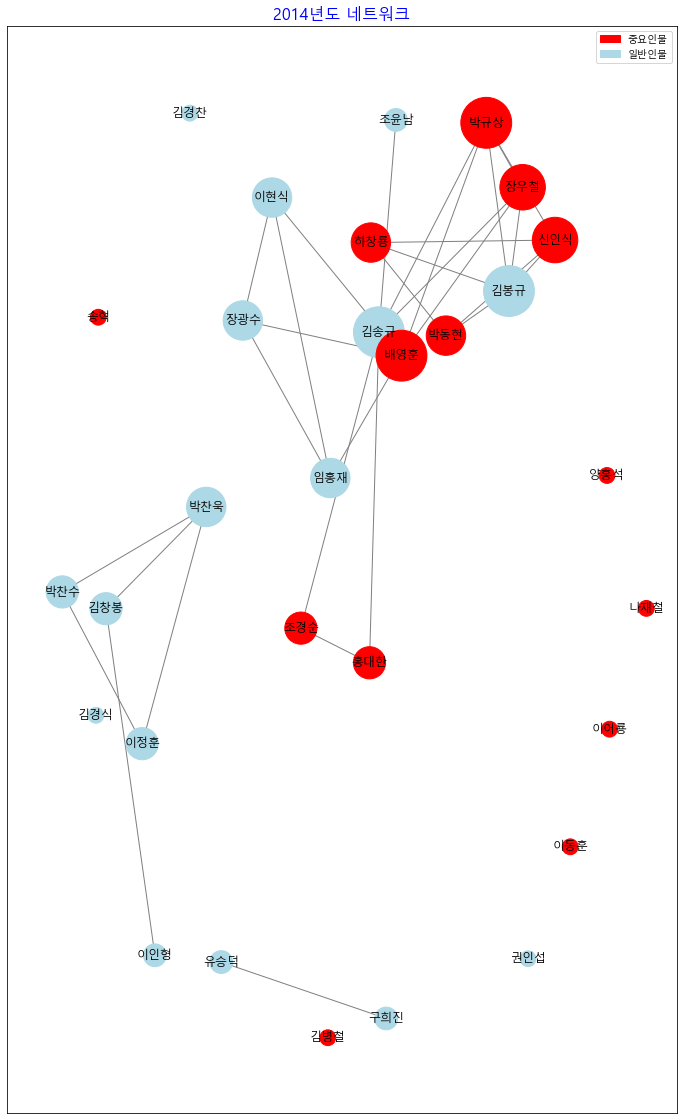

김봉규은 중요인물과 5개 연결됨
김송규은 중요인물과 4개 연결됨
신인식은 중요인물과 3개 연결됨
박규상은 중요인물과 3개 연결됨
하창룡은 중요인물과 2개 연결됨
박동현은 중요인물과 2개 연결됨
배영훈은 중요인물과 2개 연결됨
장우철은 중요인물과 2개 연결됨
이현식은 중요인물과 1개 연결됨
홍대한은 중요인물과 1개 연결됨
장광수은 중요인물과 1개 연결됨
임홍재은 중요인물과 1개 연결됨
조경순은 중요인물과 1개 연결됨
조윤남은 중요인물과 0개 연결됨
나재철은 중요인물과 0개 연결됨
이정훈은 중요인물과 0개 연결됨
송혁은 중요인물과 0개 연결됨
이동훈은 중요인물과 0개 연결됨
박찬수은 중요인물과 0개 연결됨
구희진은 중요인물과 0개 연결됨
유승덕은 중요인물과 0개 연결됨
김경식은 중요인물과 0개 연결됨
김경찬은 중요인물과 0개 연결됨
권인섭은 중요인물과 0개 연결됨
이어룡은 중요인물과 0개 연결됨
양홍석은 중요인물과 0개 연결됨
김병철은 중요인물과 0개 연결됨
김창봉은 중요인물과 0개 연결됨
박찬욱은 중요인물과 0개 연결됨
이인형은 중요인물과 0개 연결됨
2014년도 네트워크 Centrality 계산

Degree Centrality:
박규상 0.1724137931034483
김송규 0.1724137931034483
김봉규 0.1724137931034483
배영훈 0.1724137931034483
신인식 0.13793103448275862
장우철 0.13793103448275862
이현식 0.10344827586206896
하창룡 0.10344827586206896
박동현 0.10344827586206896
장광수 0.10344827586206896
임홍재 0.10344827586206896
박찬욱 0.10344827586206896
이정훈 0.06896551724137931
홍대한 0.06896551724137931
박찬수 0.06896551724137931
조경순 0.06896551724137931
김창봉 0.06896551724137931
조윤남 0.03448

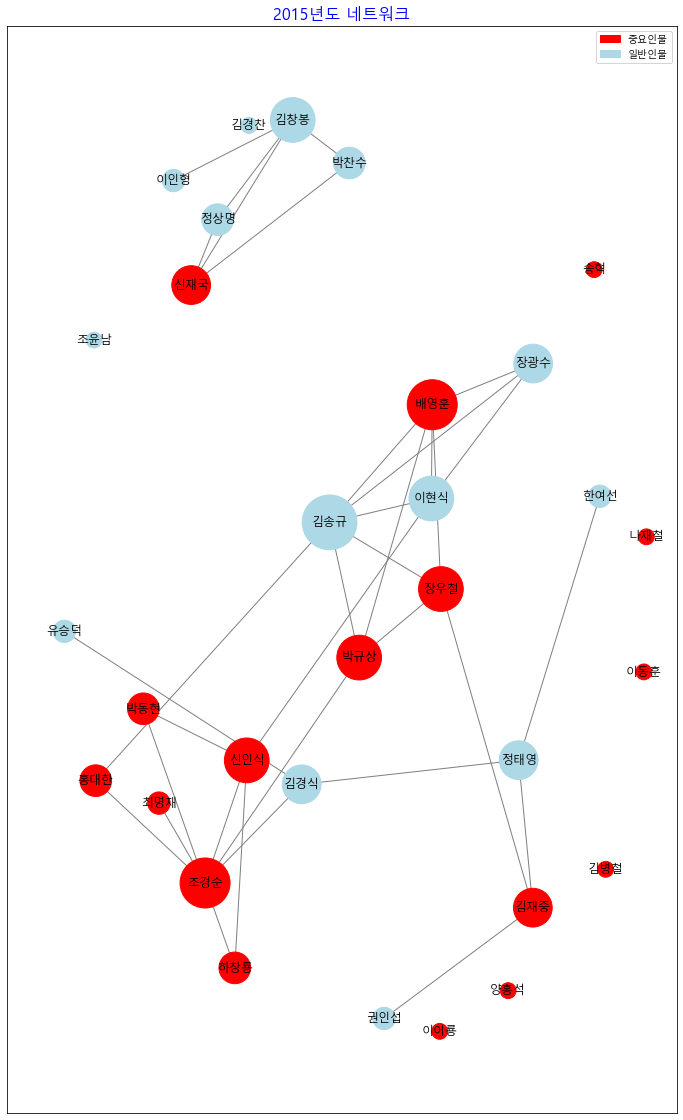

김송규은 중요인물과 4개 연결됨
조경순은 중요인물과 4개 연결됨
박규상은 중요인물과 3개 연결됨
장우철은 중요인물과 3개 연결됨
신인식은 중요인물과 3개 연결됨
하창룡은 중요인물과 2개 연결됨
배영훈은 중요인물과 2개 연결됨
박동현은 중요인물과 2개 연결됨
이현식은 중요인물과 2개 연결됨
정상명은 중요인물과 1개 연결됨
김창봉은 중요인물과 1개 연결됨
김경식은 중요인물과 1개 연결됨
홍대한은 중요인물과 1개 연결됨
정태영은 중요인물과 1개 연결됨
김재중은 중요인물과 1개 연결됨
권인섭은 중요인물과 1개 연결됨
장광수은 중요인물과 1개 연결됨
박찬수은 중요인물과 1개 연결됨
최명재은 중요인물과 1개 연결됨
김경찬은 중요인물과 0개 연결됨
유승덕은 중요인물과 0개 연결됨
김병철은 중요인물과 0개 연결됨
양홍석은 중요인물과 0개 연결됨
나재철은 중요인물과 0개 연결됨
조윤남은 중요인물과 0개 연결됨
이어룡은 중요인물과 0개 연결됨
한여선은 중요인물과 0개 연결됨
이동훈은 중요인물과 0개 연결됨
신재국은 중요인물과 0개 연결됨
송혁은 중요인물과 0개 연결됨
이인형은 중요인물과 0개 연결됨
2015년도 네트워크 Centrality 계산

Degree Centrality:
김송규 0.2
배영훈 0.16666666666666666
조경순 0.16666666666666666
박규상 0.13333333333333333
김창봉 0.13333333333333333
장우철 0.13333333333333333
신인식 0.13333333333333333
이현식 0.13333333333333333
김경식 0.1
정태영 0.1
신재국 0.1
김재중 0.1
장광수 0.1
정상명 0.06666666666666667
하창룡 0.06666666666666667
홍대한 0.06666666666666667
박동현 0.06666666666666667
박찬수 0.06666666666666667
유승덕 0.03333333333333333
한여선 0.03333333333333333
권인섭 0.0333333

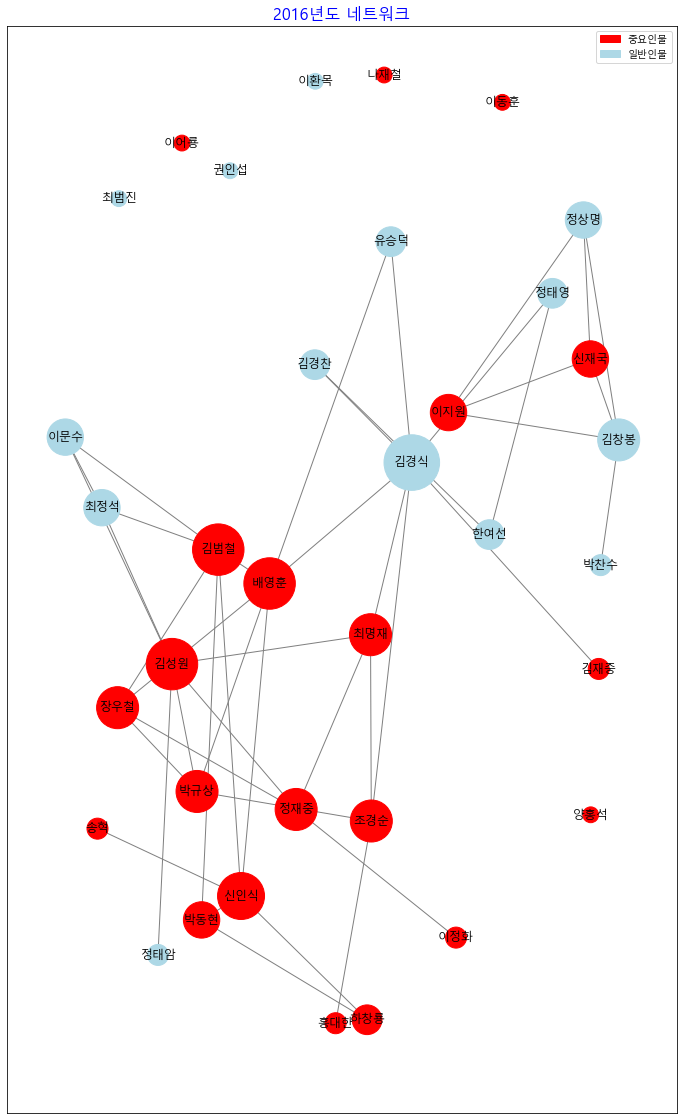

신인식은 중요인물과 5개 연결됨
장우철은 중요인물과 4개 연결됨
박규상은 중요인물과 4개 연결됨
김경식은 중요인물과 4개 연결됨
김범철은 중요인물과 4개 연결됨
정재중은 중요인물과 4개 연결됨
배영훈은 중요인물과 4개 연결됨
최명재은 중요인물과 3개 연결됨
박동현은 중요인물과 3개 연결됨
김성원은 중요인물과 3개 연결됨
조경순은 중요인물과 3개 연결됨
이문수은 중요인물과 2개 연결됨
최정석은 중요인물과 2개 연결됨
정상명은 중요인물과 2개 연결됨
김창봉은 중요인물과 2개 연결됨
하창룡은 중요인물과 2개 연결됨
송혁은 중요인물과 1개 연결됨
이정화은 중요인물과 1개 연결됨
신재국은 중요인물과 1개 연결됨
정태암은 중요인물과 1개 연결됨
홍대한은 중요인물과 1개 연결됨
유승덕은 중요인물과 1개 연결됨
이지원은 중요인물과 1개 연결됨
김재중은 중요인물과 0개 연결됨
권인섭은 중요인물과 0개 연결됨
이어룡은 중요인물과 0개 연결됨
나재철은 중요인물과 0개 연결됨
이환목은 중요인물과 0개 연결됨
김경찬은 중요인물과 0개 연결됨
정태영은 중요인물과 0개 연결됨
이동훈은 중요인물과 0개 연결됨
박찬수은 중요인물과 0개 연결됨
양홍석은 중요인물과 0개 연결됨
한여선은 중요인물과 0개 연결됨
최범진은 중요인물과 0개 연결됨
2016년도 네트워크 Centrality 계산

Degree Centrality:
김경식 0.20588235294117646
김범철 0.1764705882352941
김성원 0.1764705882352941
배영훈 0.1764705882352941
신인식 0.14705882352941177
최명재 0.11764705882352941
장우철 0.11764705882352941
박규상 0.11764705882352941
정재중 0.11764705882352941
조경순 0.11764705882352941
김창봉 0.11764705882352941
신재국 0.08823529411764705
이문수 0.08823529411764705
박동현 0.0882352941

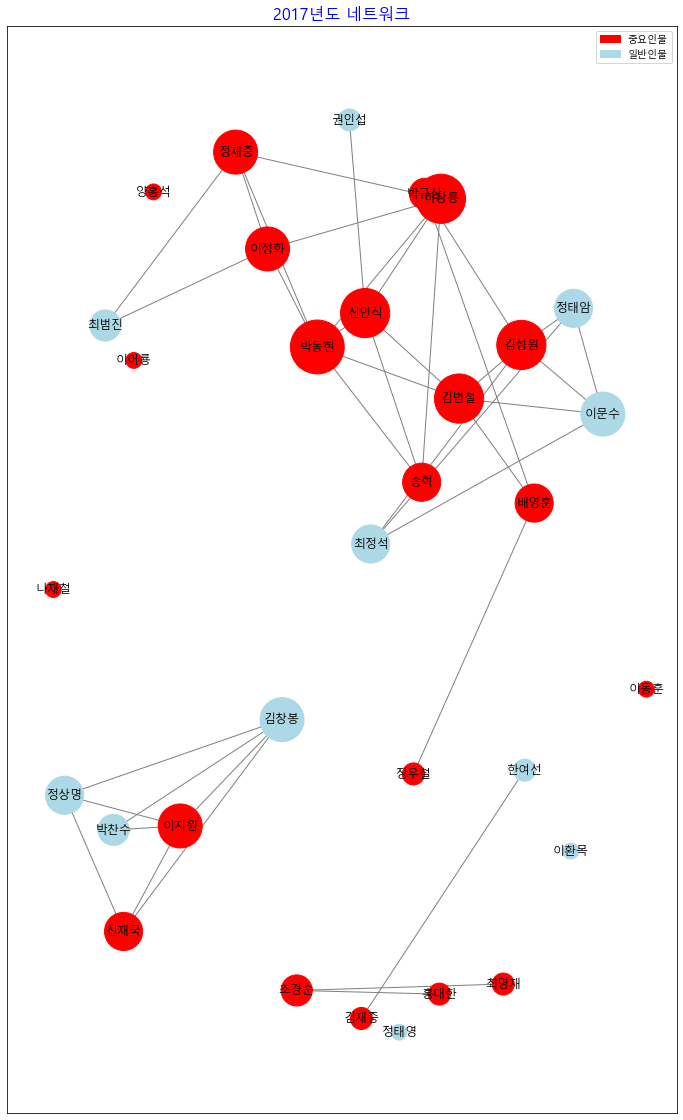

박동현은 중요인물과 6개 연결됨
하창룡은 중요인물과 5개 연결됨
김범철은 중요인물과 4개 연결됨
신인식은 중요인물과 4개 연결됨
송혁은 중요인물과 3개 연결됨
이정화은 중요인물과 3개 연결됨
배영훈은 중요인물과 3개 연결됨
정재중은 중요인물과 3개 연결됨
최범진은 중요인물과 2개 연결됨
김창봉은 중요인물과 2개 연결됨
조경순은 중요인물과 2개 연결됨
김성원은 중요인물과 2개 연결됨
이문수은 중요인물과 2개 연결됨
정상명은 중요인물과 2개 연결됨
박규상은 중요인물과 2개 연결됨
정태암은 중요인물과 1개 연결됨
이지원은 중요인물과 1개 연결됨
최정석은 중요인물과 1개 연결됨
장우철은 중요인물과 1개 연결됨
홍대한은 중요인물과 1개 연결됨
최명재은 중요인물과 1개 연결됨
박찬수은 중요인물과 1개 연결됨
신재국은 중요인물과 1개 연결됨
한여선은 중요인물과 1개 연결됨
권인섭은 중요인물과 1개 연결됨
이어룡은 중요인물과 0개 연결됨
김재중은 중요인물과 0개 연결됨
정태영은 중요인물과 0개 연결됨
이동훈은 중요인물과 0개 연결됨
이환목은 중요인물과 0개 연결됨
나재철은 중요인물과 0개 연결됨
양홍석은 중요인물과 0개 연결됨
2017년도 네트워크 Centrality 계산

Degree Centrality:
박동현 0.1935483870967742
김성원 0.16129032258064516
김범철 0.16129032258064516
하창룡 0.16129032258064516
신인식 0.16129032258064516
김창봉 0.12903225806451613
이지원 0.12903225806451613
이정화 0.12903225806451613
이문수 0.12903225806451613
정재중 0.12903225806451613
정태암 0.0967741935483871
송혁 0.0967741935483871
최정석 0.0967741935483871
배영훈 0.0967741935483871
정상명 0.0967741935483871
신재국 0.0967741935483871
최범진

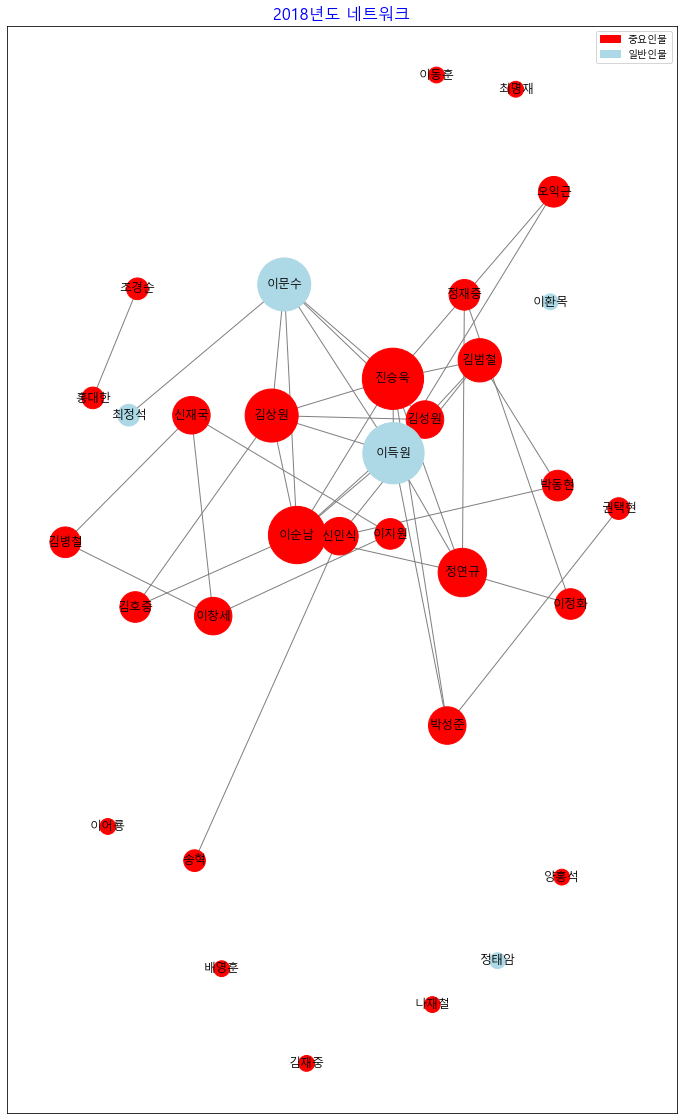

이득원은 중요인물과 7개 연결됨
진승욱은 중요인물과 6개 연결됨
이순남은 중요인물과 5개 연결됨
정연규은 중요인물과 4개 연결됨
김상원은 중요인물과 4개 연결됨
이문수은 중요인물과 4개 연결됨
이창세은 중요인물과 3개 연결됨
신인식은 중요인물과 3개 연결됨
김범철은 중요인물과 3개 연결됨
신재국은 중요인물과 3개 연결됨
박성준은 중요인물과 2개 연결됨
김병철은 중요인물과 2개 연결됨
박동현은 중요인물과 2개 연결됨
김성원은 중요인물과 2개 연결됨
정재중은 중요인물과 2개 연결됨
이지원은 중요인물과 2개 연결됨
김호중은 중요인물과 2개 연결됨
이정화은 중요인물과 2개 연결됨
오익근은 중요인물과 1개 연결됨
조경순은 중요인물과 1개 연결됨
권택현은 중요인물과 1개 연결됨
홍대한은 중요인물과 1개 연결됨
송혁은 중요인물과 1개 연결됨
정태암은 중요인물과 0개 연결됨
이환목은 중요인물과 0개 연결됨
김재중은 중요인물과 0개 연결됨
최정석은 중요인물과 0개 연결됨
이어룡은 중요인물과 0개 연결됨
배영훈은 중요인물과 0개 연결됨
양홍석은 중요인물과 0개 연결됨
최명재은 중요인물과 0개 연결됨
이동훈은 중요인물과 0개 연결됨
나재철은 중요인물과 0개 연결됨
2018년도 네트워크 Centrality 계산

Degree Centrality:
진승욱 0.25
이득원 0.25
이순남 0.21875
김상원 0.1875
이문수 0.1875
정연규 0.15625
김범철 0.125
박성준 0.09375
이창세 0.09375
김성원 0.09375
신인식 0.09375
신재국 0.09375
김병철 0.0625
오익근 0.0625
박동현 0.0625
정재중 0.0625
이지원 0.0625
김호중 0.0625
이정화 0.0625
최정석 0.03125
조경순 0.03125
권택현 0.03125
홍대한 0.03125
송혁 0.03125
정태암 0.0
이환목 0.0
김재중 0.0
이어룡 0.0
배영훈 0.0
양홍석 0.0
최명재 0.0
이동훈 0.0
나재철 0.0

Betweenness Centra

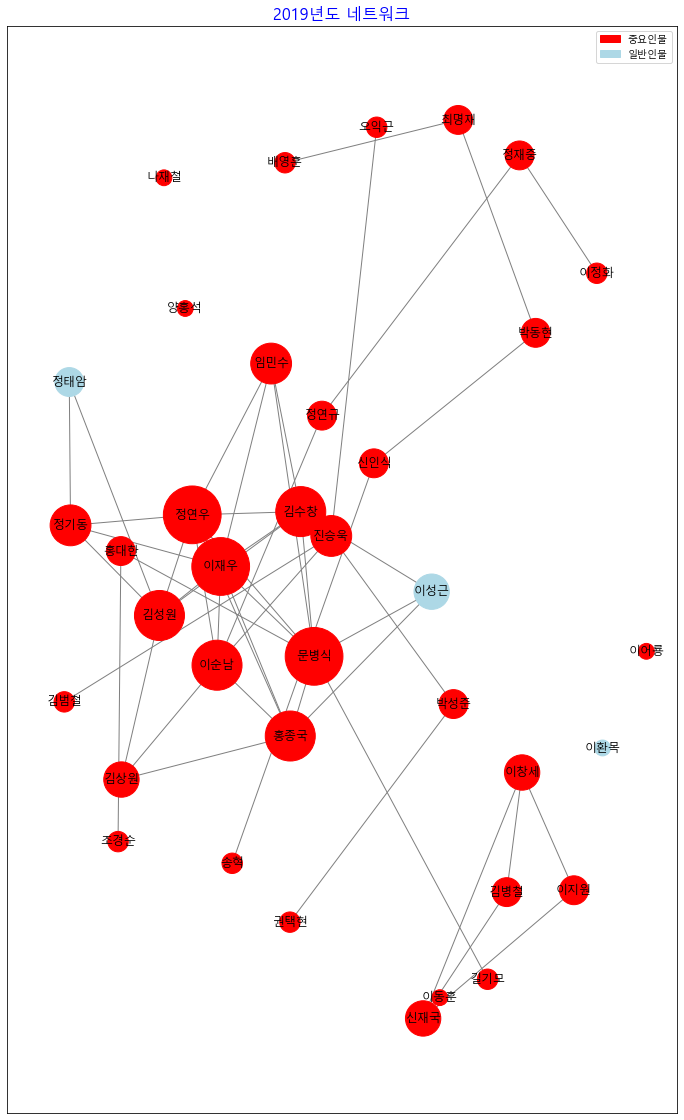

이재우은 중요인물과 8개 연결됨
정연우은 중요인물과 8개 연결됨
문병식은 중요인물과 7개 연결됨
이순남은 중요인물과 6개 연결됨
홍종국은 중요인물과 5개 연결됨
김수창은 중요인물과 5개 연결됨
김성원은 중요인물과 5개 연결됨
진승욱은 중요인물과 4개 연결됨
임민수은 중요인물과 4개 연결됨
신재국은 중요인물과 3개 연결됨
정기동은 중요인물과 3개 연결됨
이창세은 중요인물과 3개 연결됨
김상원은 중요인물과 3개 연결됨
이성근은 중요인물과 3개 연결됨
최명재은 중요인물과 2개 연결됨
박동현은 중요인물과 2개 연결됨
정태암은 중요인물과 2개 연결됨
김병철은 중요인물과 2개 연결됨
정재중은 중요인물과 2개 연결됨
박성준은 중요인물과 2개 연결됨
이지원은 중요인물과 2개 연결됨
정연규은 중요인물과 2개 연결됨
홍대한은 중요인물과 2개 연결됨
신인식은 중요인물과 2개 연결됨
권택현은 중요인물과 1개 연결됨
조경순은 중요인물과 1개 연결됨
배영훈은 중요인물과 1개 연결됨
김범철은 중요인물과 1개 연결됨
길기모은 중요인물과 1개 연결됨
이정화은 중요인물과 1개 연결됨
송혁은 중요인물과 1개 연결됨
오익근은 중요인물과 1개 연결됨
이환목은 중요인물과 0개 연결됨
이동훈은 중요인물과 0개 연결됨
양홍석은 중요인물과 0개 연결됨
이어룡은 중요인물과 0개 연결됨
나재철은 중요인물과 0개 연결됨
2019년도 네트워크 Centrality 계산

Degree Centrality:
이재우 0.2222222222222222
정연우 0.2222222222222222
문병식 0.2222222222222222
홍종국 0.16666666666666666
김수창 0.16666666666666666
김성원 0.16666666666666666
이순남 0.16666666666666666
진승욱 0.1111111111111111
정기동 0.1111111111111111
임민수 0.1111111111111111
신재국 0.08333333333333333
이창세 0.08333333333333333
김상원 0.0

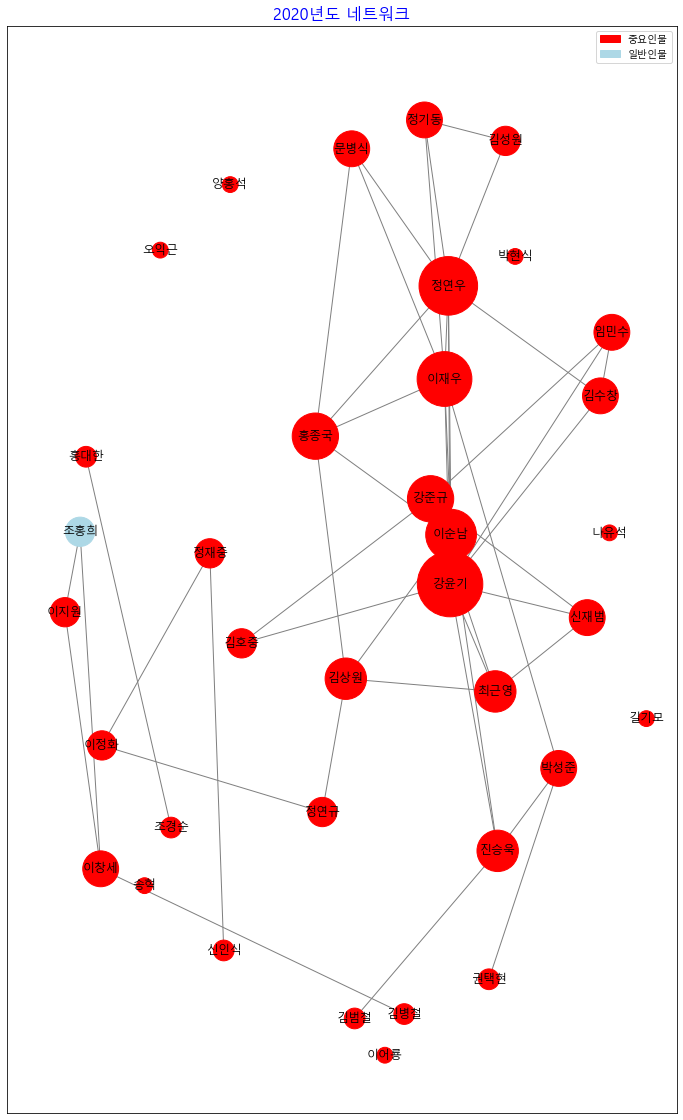

강윤기은 중요인물과 10개 연결됨
정연우은 중요인물과 8개 연결됨
이재우은 중요인물과 7개 연결됨
이순남은 중요인물과 6개 연결됨
홍종국은 중요인물과 5개 연결됨
강준규은 중요인물과 5개 연결됨
진승욱은 중요인물과 4개 연결됨
김상원은 중요인물과 4개 연결됨
최근영은 중요인물과 4개 연결됨
박성준은 중요인물과 3개 연결됨
임민수은 중요인물과 3개 연결됨
정기동은 중요인물과 3개 연결됨
김수창은 중요인물과 3개 연결됨
신재범은 중요인물과 3개 연결됨
문병식은 중요인물과 3개 연결됨
이정화은 중요인물과 2개 연결됨
정재중은 중요인물과 2개 연결됨
김성원은 중요인물과 2개 연결됨
정연규은 중요인물과 2개 연결됨
김호중은 중요인물과 2개 연결됨
이창세은 중요인물과 2개 연결됨
조홍희은 중요인물과 2개 연결됨
김병철은 중요인물과 1개 연결됨
신인식은 중요인물과 1개 연결됨
조경순은 중요인물과 1개 연결됨
김범철은 중요인물과 1개 연결됨
권택현은 중요인물과 1개 연결됨
홍대한은 중요인물과 1개 연결됨
이지원은 중요인물과 1개 연결됨
오익근은 중요인물과 0개 연결됨
길기모은 중요인물과 0개 연결됨
송혁은 중요인물과 0개 연결됨
박현식은 중요인물과 0개 연결됨
나유석은 중요인물과 0개 연결됨
이어룡은 중요인물과 0개 연결됨
양홍석은 중요인물과 0개 연결됨
2020년도 네트워크 Centrality 계산

Degree Centrality:
강윤기 0.2857142857142857
정연우 0.22857142857142856
이재우 0.19999999999999998
이순남 0.17142857142857143
홍종국 0.14285714285714285
강준규 0.14285714285714285
진승욱 0.11428571428571428
김상원 0.11428571428571428
최근영 0.11428571428571428
박성준 0.08571428571428572
임민수 0.08571428571428572
정기동 0.08571428571428572
이창세 0.0857142857142

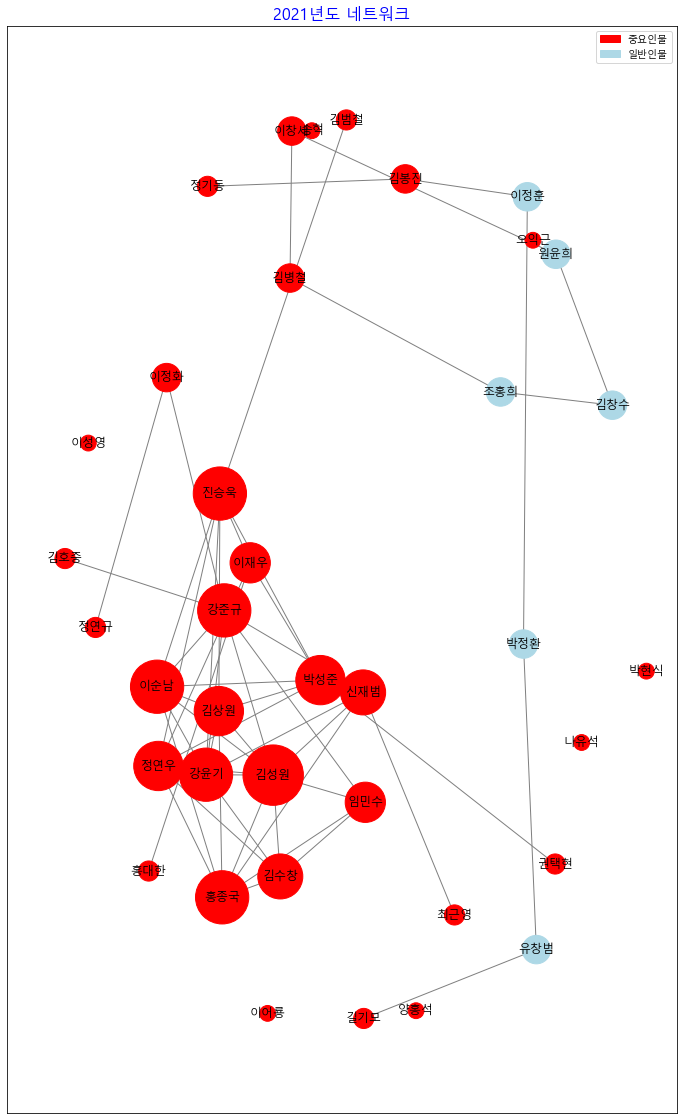

김성원은 중요인물과 9개 연결됨
강준규은 중요인물과 7개 연결됨
진승욱은 중요인물과 7개 연결됨
이순남은 중요인물과 7개 연결됨
강윤기은 중요인물과 7개 연결됨
홍종국은 중요인물과 7개 연결됨
정연우은 중요인물과 6개 연결됨
김상원은 중요인물과 6개 연결됨
박성준은 중요인물과 6개 연결됨
신재범은 중요인물과 5개 연결됨
김수창은 중요인물과 5개 연결됨
이재우은 중요인물과 4개 연결됨
임민수은 중요인물과 4개 연결됨
이정화은 중요인물과 2개 연결됨
김범철은 중요인물과 1개 연결됨
김병철은 중요인물과 1개 연결됨
원윤희은 중요인물과 1개 연결됨
이정훈은 중요인물과 1개 연결됨
정기동은 중요인물과 1개 연결됨
정연규은 중요인물과 1개 연결됨
이창세은 중요인물과 1개 연결됨
김봉진은 중요인물과 1개 연결됨
최근영은 중요인물과 1개 연결됨
조홍희은 중요인물과 1개 연결됨
홍대한은 중요인물과 1개 연결됨
유창범은 중요인물과 1개 연결됨
김호중은 중요인물과 1개 연결됨
권택현은 중요인물과 1개 연결됨
이어룡은 중요인물과 0개 연결됨
양홍석은 중요인물과 0개 연결됨
이성영은 중요인물과 0개 연결됨
박정환은 중요인물과 0개 연결됨
박현식은 중요인물과 0개 연결됨
김창수은 중요인물과 0개 연결됨
오익근은 중요인물과 0개 연결됨
나유석은 중요인물과 0개 연결됨
길기모은 중요인물과 0개 연결됨
송혁은 중요인물과 0개 연결됨
2021년도 네트워크 Centrality 계산

Degree Centrality:
김성원 0.24324324324324326
강준규 0.1891891891891892
진승욱 0.1891891891891892
이순남 0.1891891891891892
강윤기 0.1891891891891892
홍종국 0.1891891891891892
정연우 0.16216216216216217
김상원 0.16216216216216217
박성준 0.16216216216216217
신재범 0.13513513513513514
김수창 0.13513513513513514
이재우 0.108108

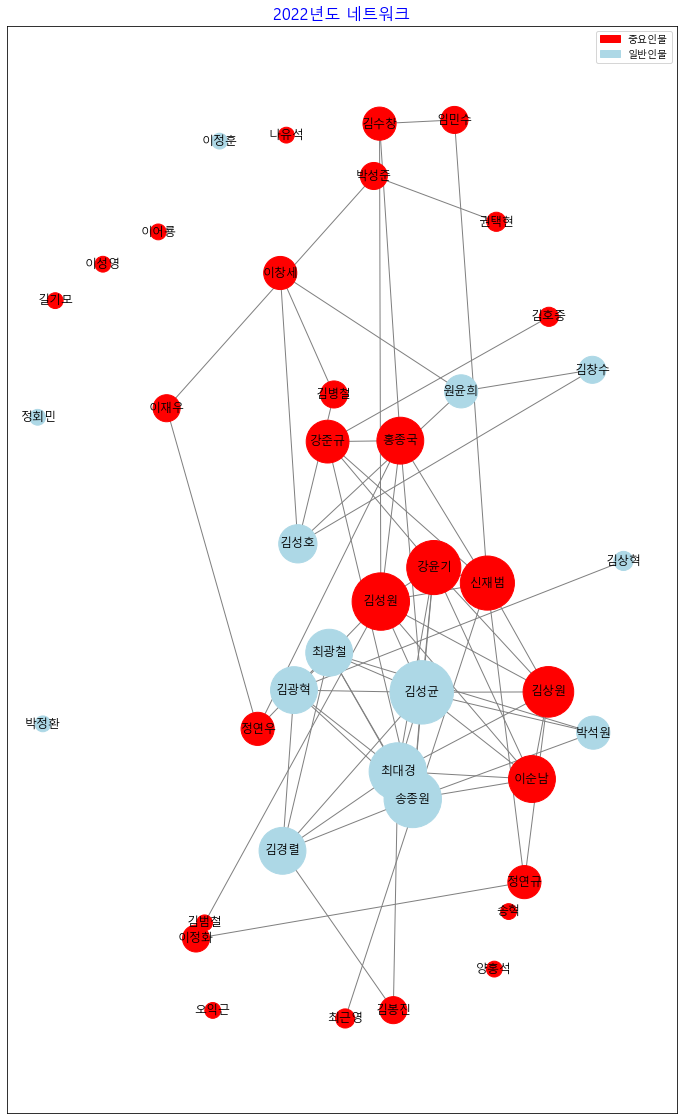

김성원은 중요인물과 8개 연결됨
신재범은 중요인물과 8개 연결됨
김성균은 중요인물과 5개 연결됨
홍종국은 중요인물과 5개 연결됨
김상원은 중요인물과 5개 연결됨
강윤기은 중요인물과 5개 연결됨
강준규은 중요인물과 4개 연결됨
최대경은 중요인물과 4개 연결됨
이순남은 중요인물과 3개 연결됨
김수창은 중요인물과 3개 연결됨
정연우은 중요인물과 3개 연결됨
정연규은 중요인물과 3개 연결됨
송종원은 중요인물과 3개 연결됨
이정화은 중요인물과 2개 연결됨
이재우은 중요인물과 2개 연결됨
김성호은 중요인물과 2개 연결됨
임민수은 중요인물과 2개 연결됨
박성준은 중요인물과 2개 연결됨
최근영은 중요인물과 1개 연결됨
김병철은 중요인물과 1개 연결됨
권택현은 중요인물과 1개 연결됨
이창세은 중요인물과 1개 연결됨
김경렬은 중요인물과 1개 연결됨
원윤희은 중요인물과 1개 연결됨
김호중은 중요인물과 1개 연결됨
박정환은 중요인물과 0개 연결됨
최광철은 중요인물과 0개 연결됨
길기모은 중요인물과 0개 연결됨
송혁은 중요인물과 0개 연결됨
김봉진은 중요인물과 0개 연결됨
정회민은 중요인물과 0개 연결됨
박석원은 중요인물과 0개 연결됨
이정훈은 중요인물과 0개 연결됨
오익근은 중요인물과 0개 연결됨
이성영은 중요인물과 0개 연결됨
김상혁은 중요인물과 0개 연결됨
나유석은 중요인물과 0개 연결됨
이어룡은 중요인물과 0개 연결됨
양홍석은 중요인물과 0개 연결됨
김범철은 중요인물과 0개 연결됨
김창수은 중요인물과 0개 연결됨
김광혁은 중요인물과 0개 연결됨
2022년도 네트워크 Centrality 계산

Degree Centrality:
김성균 0.2682926829268293
김성원 0.21951219512195122
최대경 0.21951219512195122
송종원 0.21951219512195122
강윤기 0.1951219512195122
신재범 0.1951219512195122
김상원 0.17073170731707318
이순남 0.14634146341463417
최광철 0.1463

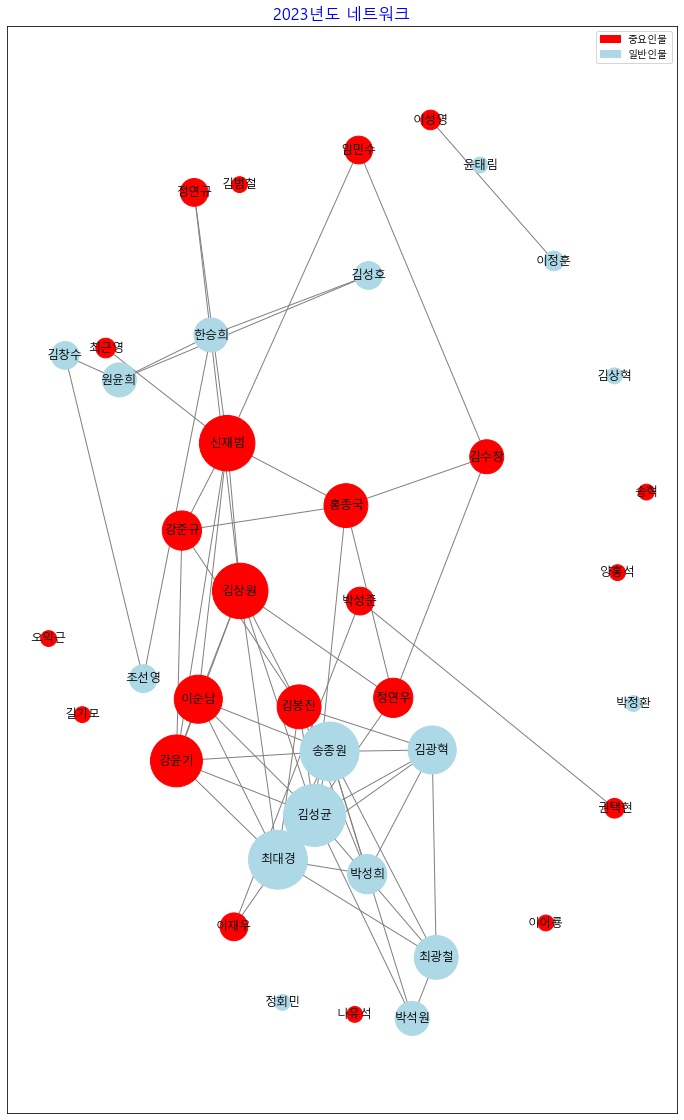

신재범은 중요인물과 8개 연결됨
김상원은 중요인물과 6개 연결됨
김성균은 중요인물과 5개 연결됨
강윤기은 중요인물과 4개 연결됨
정연우은 중요인물과 4개 연결됨
최대경은 중요인물과 4개 연결됨
홍종국은 중요인물과 4개 연결됨
강준규은 중요인물과 3개 연결됨
이순남은 중요인물과 3개 연결됨
송종원은 중요인물과 3개 연결됨
김수창은 중요인물과 3개 연결됨
이재우은 중요인물과 2개 연결됨
박성준은 중요인물과 2개 연결됨
임민수은 중요인물과 2개 연결됨
정연규은 중요인물과 2개 연결됨
김봉진은 중요인물과 1개 연결됨
최근영은 중요인물과 1개 연결됨
권택현은 중요인물과 1개 연결됨
박성희은 중요인물과 1개 연결됨
김광혁은 중요인물과 1개 연결됨
이정훈은 중요인물과 1개 연결됨
김성호은 중요인물과 0개 연결됨
양홍석은 중요인물과 0개 연결됨
정회민은 중요인물과 0개 연결됨
박석원은 중요인물과 0개 연결됨
박정환은 중요인물과 0개 연결됨
송혁은 중요인물과 0개 연결됨
김창수은 중요인물과 0개 연결됨
최광철은 중요인물과 0개 연결됨
김상혁은 중요인물과 0개 연결됨
이성영은 중요인물과 0개 연결됨
나유석은 중요인물과 0개 연결됨
조선영은 중요인물과 0개 연결됨
원윤희은 중요인물과 0개 연결됨
오익근은 중요인물과 0개 연결됨
윤태림은 중요인물과 0개 연결됨
이어룡은 중요인물과 0개 연결됨
길기모은 중요인물과 0개 연결됨
김범철은 중요인물과 0개 연결됨
한승희은 중요인물과 0개 연결됨
2023년도 네트워크 Centrality 계산

Degree Centrality:
김성균 0.2564102564102564
송종원 0.23076923076923075
최대경 0.23076923076923075
신재범 0.20512820512820512
김상원 0.20512820512820512
강윤기 0.1794871794871795
이순남 0.15384615384615385
김광혁 0.15384615384615385
김봉진 0.1282051282051282
최광철 0.1282051282051282

In [80]:
print_network(matrixs)